In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from modules import download_catalogs

In [2]:
catalogs = [
    "B/vsx/vsx",
]

# Download only missing catalogs
parquet_files = download_catalogs(catalogs)

Processing catalogs: 100%|██████████| 1/1 [00:00<00:00, 2998.07it/s]

Skipping B/vsx/vsx - already exists


In [3]:
base_name = "B_vsx_vsx" # Имя файла без разрешения
df = pd.read_parquet(f"data/{base_name}.parquet")
df.head()

,OID,n_OID,Name,V,Type,l_max,max,u_max,n_max,f_min,l_min,min,u_min,n_min,l_Period,Period,u_Period,Sp,RAJ2000,DEJ2000
0,8278100,,Gaia DR3 4685168858707787776,0,L,,16.59,,G,,,17.740000,,G,,NaN,,K,0.00006,-75.86906
1,2535232,,Gaia DR3 2881873169572728832,0,ROT,,16.59,,G,,,16.639999,,G,,2.35407,,G,0.00013,39.89248
2,2535233,,Gaia DR3 4918216945285915648,0,RR,,17.07,,G,,,17.600000,,G,,NaN,,F,0.00019,-59.55921
3,2535234,,Gaia DR3 566749663745310848,0,ROT,,15.57,,G,,,15.620000,,G,,NaN,,K,0.00038,81.91627
4,2535235,,Gaia DR3 430093700005970048,0,ROT,,14.50,,G,,,14.530000,,G,,NaN,,F,0.00043,63.43314


In [4]:
def classify_type(vtype: str) -> str:
    """
    Классифицирует тип переменной звезды в одну из укрупнённых категорий.
    """
    if pd.isna(vtype) or not isinstance(vtype, str) or vtype.strip() == "":
        return "UNKNOWN"
    
    t = vtype.upper()
    
    # Список условий для классификации
    if any(m in t for m in ["EA", "EB", "EW", "EC", "ELL", "E/RS", "E|", "E "]):
        return "ECLIPSING"
    elif any(m in t for m in ["DCEP", "CW-FU", "CW", "CWA", "CWB", "RVA", "RV", "ACEP", "CEP"]):
        return "CEPHEIDS"
    elif any(m in t for m in ["RRAB", "RRC", "RRD", "RR"]):
        return "RR_LYRAE"
    elif any(m in t for m in ["DSCT", "HADS", "SXPHE", "GDOR", "ROAP", "ROAM"]):
        return "DELTA_SCUTI_ETC"
    elif any(m in t for m in ["M", "SR", "SRA", "SRB", "SRC", "SRD", "L", "LB", "LC", "LPV"]):
        return "LONG_PERIOD"
    elif any(m in t for m in ["BY", "RS", "ACV", "SPB", "ROT", "GCAS"]):
        return "ROTATIONAL"
    elif any(m in t for m in ["TTS", "EXOR", "UXOR", "INS", "IN", "INST"]):
        return "YSO/ERUPTIVE"
    elif any(m in t for m in ["UG", "NL", "AM", "ZAND", "IB", "ISB"]):
        return "CATACLYSMIC"
    elif any(m in t for m in ["WR", "BE", "FSCMA"]):
        return "EMISSION_WR"
    else:
        return "UNKNOWN"

def preprocess_data(df):
    # Удаление ненужных столбцов
    drop_columns = ["V", "OID", "n_OID", "Name", "RAJ2000", "DEJ2000",
                    'l_max', 'u_max', 'n_max', 'f_min', 'l_min', 'u_min', 
                    'n_min', 'l_Period', 'u_Period']
    df = df.drop(columns=drop_columns)
    
    # Удаление строк с пропусками
    df = df.dropna()
    
    # Фильтрация спектральных типов
    valid_spectral_types = ['K', 'F', 'M', 'G', 'A', 'B', 'O', 'C']
    df = df[df['Sp'].isin(valid_spectral_types)]
    
    # Классификация типов переменных и фильтрация
    df['class'] = df['Type'].apply(classify_type)
    df = df[~df['class'].isin(['YSO/ERUPTIVE', 'EMISSION_WR', 'UNKNOWN'])]
    df = df.drop(columns=["Type"])
    
    return df

# Применение функции
df = preprocess_data(df)

In [5]:
new_name = "mul_class"
df.to_parquet(f"data/{new_name}.parquet")
df

,max,min,Period,Sp,class
1,16.590000,16.639999,2.354070,G,ROTATIONAL
21,14.690000,14.710000,0.351222,F,ROTATIONAL
44,15.990000,16.030001,5.835500,K,ROTATIONAL
48,15.090000,15.100000,4.552810,K,ROTATIONAL
84,13.150000,13.190000,0.081240,F,DELTA_SCUTI_ETC
...,...,...,...,...,...
9750356,17.219999,17.250000,0.579000,K,ROTATIONAL
9750362,15.800000,15.830000,2.892950,F,ROTATIONAL
9750369,15.440000,15.450000,0.341194,F,ROTATIONAL
9750403,17.150000,17.190001,0.395843,M,ROTATIONAL


2025-05-02 11:56:43.173437: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 11:56:43.180512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746176203.187707 1831873 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746176203.190037 1831873 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 11:56:43.198646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/100
6036/6036 ━━━━━━━━━━━━━━━━━━━━ 4s 666us/step - accuracy: 0.7006 - loss: 10.6404 - val_accuracy: 0.8467 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 2/100
6036/6036 ━━━━━━━━━━━━━━━━━━━━ 4s 653us/step - accuracy: 0.8566 - loss: 4.2724 - val_accuracy: 0.8177 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 3/100
6036/6036 ━━━━━━━━━━━━━━━━━━━━ 4s 654us/step - accuracy: 0.8660 - loss: 3.9265 - val_accuracy: 0.8572 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 4/100
6036/6036 ━━━━━━━━━━━━━━━━━━━━ 4s 659us/step - accuracy: 0.8703 - loss: 3.7296 - val_accuracy: 0.8636 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 5/100
6036/6036 ━━━━━━━━━━━━━━━━━━━━ 4s 657us/step - accuracy: 0.8727 - loss: 3.6550 - val_accuracy: 0.8628 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 6/100
6036/6036 ━━━━━━━━━━━━━━━━━━━━ 4s 669us/step - accuracy: 0.8739 - loss: 3.6020 - val_accuracy: 0.8670 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 7/100
6036/6036 ━━━━━━━━━━━━━━━━━━━━ 4s 659us/step 

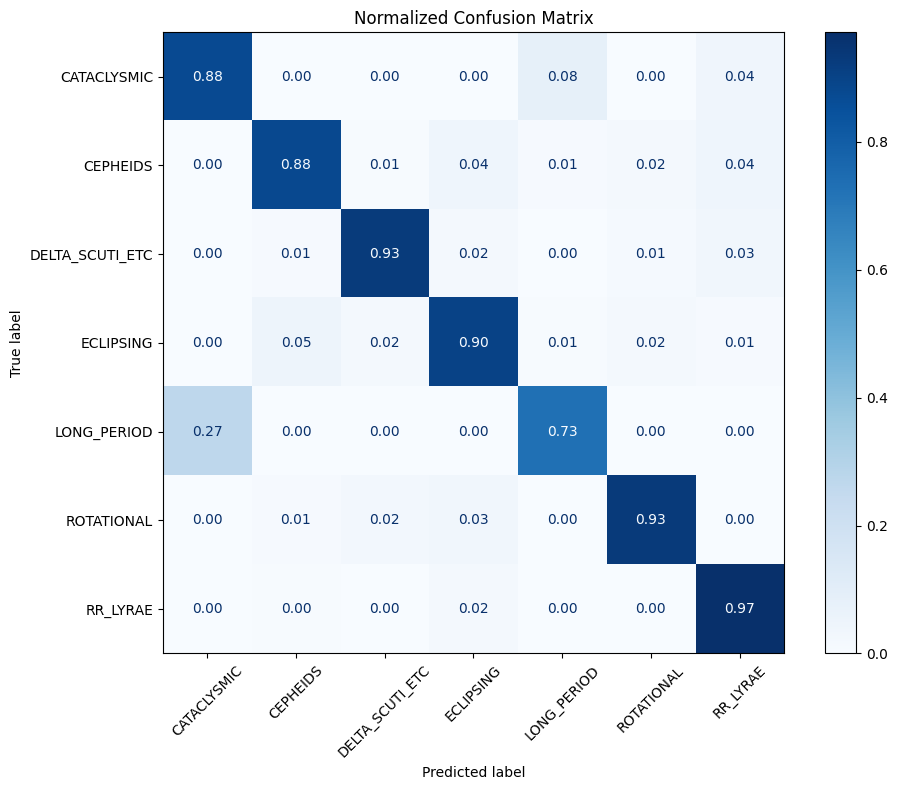

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras import layers, Model, callbacks, optimizers
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import (classification_report, 
                            ConfusionMatrixDisplay, 
                            matthews_corrcoef)
import matplotlib.pyplot as plt
import tensorflow as tf

# Data preparation
num_cols = ['max', 'min', 'Period']
sp_col = 'Sp'
target_col = 'class'

# Create Sp lookup
sp_categories = pd.unique(df[sp_col])
sp_lookup = {s: i for i, s in enumerate(sp_categories)}
sp_int = df[sp_col].map(sp_lookup).values

# Prepare features and target
X_num = df[num_cols].values
y = pd.Categorical(df[target_col]).codes

# Split data with stratification
X_num_temp, X_num_test, sp_int_temp, sp_int_test, y_temp, y_test = train_test_split(
    X_num, sp_int, y, test_size=0.2, stratify=y, random_state=42)

X_num_train, X_num_val, sp_int_train, sp_int_val, y_train, y_val = train_test_split(
    X_num_temp, sp_int_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_val_scaled = scaler.transform(X_num_val)
X_num_test_scaled = scaler.transform(X_num_test)

# Combine features for SMOTE-NC
X_train_combined = np.hstack([
    X_num_train_scaled, 
    sp_int_train.reshape(-1, 1)
])

# Apply SMOTE-NC (handles categorical features)
smote_nc = SMOTENC(
    categorical_features=[3],  # Index of Sp column
    random_state=42,
    sampling_strategy='not majority'  # Oversample all except majority class
)
X_resampled, y_resampled = smote_nc.fit_resample(X_train_combined, y_train)

# Split back into components
X_num_resampled = X_resampled[:, :3]
sp_int_resampled = X_resampled[:, 3].astype(int)

# Focal loss for sparse labels
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1. - 1e-7)
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])
        cross_entropy = -y_true_onehot * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma) * y_true_onehot
        return tf.reduce_mean(tf.reduce_sum(weight * cross_entropy, axis=-1))
    return loss

# Model architecture
num_input = layers.Input(shape=(3,), name='num_input')
sp_input = layers.Input(shape=(1,), name='sp_input')

sp_embed = layers.Embedding(len(sp_categories), 2)(sp_input)
sp_embed = layers.Flatten()(sp_embed)

concat = layers.Concatenate()([num_input, sp_embed])
x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(concat)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(len(np.unique(y)), activation='softmax')(x)

model = Model(inputs=[num_input, sp_input], outputs=output)

# Class weights from original distribution
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

# Callbacks
es = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    min_delta=0.001
)
rlr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=5,
    min_lr=1e-6
)

# Training
history = model.fit(
    [X_num_resampled, sp_int_resampled], y_resampled,
    validation_data=([X_num_val_scaled, sp_int_val], y_val),
    epochs=100,
    batch_size=256,
    callbacks=[es, rlr],
    class_weight=class_weights
)

# Evaluation
y_pred = np.argmax(model.predict([X_num_test_scaled, sp_int_test]), axis=1)
class_names = pd.Categorical(df[target_col]).categories

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

print("\nMatthews Correlation Coefficient:", 
      matthews_corrcoef(y_test, y_pred).round(3))

# Normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=class_names,
    normalize='true',
    xticks_rotation=45,
    cmap='Blues',
    ax=ax,
    values_format='.2f'
)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()